# Tugas 1 CVL | Image Processing
---
**Nama:** Frederik Baptista Sakspari

**NIM:** 24/550780/PPA/06957

---

Referensi yang digunakan untuk membuat kode dalam preject ini berasal dari buku **The second edition of Computer Vision: Algorithms and Applications by Richard Szeliski** dab beberapa link terkait:

* https://en.wikipedia.org/wiki/Histogram_equalization

* https://youtu.be/bQ1syT8X0oA

Kasus yang ditangani dalam Tugas ini adalah masalah pada citra yang terlalu gelap atau citra yang terlalu terang dengan metode Histogram Equalization. Karena fokusnya pada kecerahan citra, maka proses ini akan diimplementasikan pada kanal Luminance (L) dari citra.

Metode yang coba diimplementasikan dalam tugas ini meliputi:
* Global Histogram Equalization
* Block Histogram Equalization (Local Histogram Equalization)
* Adaptive Histogram Equalization (AHE)

Hasil akhir dari metode ini kemudian di komparasi


#### Histogram Equalization

In [70]:
# import library
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [71]:
# define fungsi untuk load image
def load_image(img_path):
    try:
        # load citra menggunakan Pillow
        original_image = Image.open(img_path)
        print(f"Berhasil memuat citra: {img_path}")
    except FileNotFoundError:
        print(f"File '{img_path}' tidak ditemukan...")

    # metode histogram equalization yang dibuat akan diaplikasikan pada kanal L (Luminance)
    grayscale_image = original_image.convert('L')

    # konversi citra menjadi array
    np_image = np.array(grayscale_image)

    return np_image

In [72]:
# np_img = load_image('./dataset/dark.png')
# np_img.size
# np_img.shape
# np_img.flatten()


In [73]:
# define fungsi untuk kalkulasi histogram dari citra
def calc_histogram(np_img):
    # buat array ukuran 256 untuk menyimpan jumlah pixel setiap intensitas (0-255).
    # Inisialisasi semua hitungan dengan nilai 0.
    histogram = np.zeros(256, dtype=int)

    # hitung jumlah pixel pada setiap intensitas.
    # .flatten() mengubah matriks 2D menjadi array 1D agar mudah diiterasi.
    for pixel_value in np_img.flatten():
        # Tambahkan 1 pada (indeks) yang sesuai dengan nilai piksel.
        # Contoh: if piksel adalah 80, maka histogram[80] akan bertambah 1.
        histogram[pixel_value] += 1

    # shortcut bisa pakai bincount dari numpy
    # histogram = np.bincount(np_img.flatten(), minlength=256)
            
    return histogram

Buat fungsi untuk mengkalkulasi nilai CDF. Formula c(I) di definisikan sebagai:

$$c(I)=c(I−1)+h(I)$$

dengan:

c(I): Nilai CDF (jumlah kumulatif) pada tingkat kecerahan I.

c(I-1): Nilai CDF pada tingkat kecerahan sebelumnya.

h(I): Jumlah piksel pada tingkat kecerahan I saat ini (dari histogram).

In [74]:
# gitung cfd
def calc_cdf(histogram):
    # Buat array kosong untuk menyimpan nilai CDF
    cdf = np.zeros(256, dtype=int)
    
    # Nilai CDF pertama sama dengan nilai histogram pertama
    cdf[0] = histogram[0]
    
    # Lakukan iterasi dari 1 hingga 255 untuk menghitung total cdf
    for i in range(1, 256):
        cdf[i] = cdf[i-1] + histogram[i]
        
    return cdf

In [75]:
def mapping(np_img, cdf):
    hv = np.zeros(256, dtype=np.uint8)
    cdf_min = cdf[np.nonzero(cdf)][0] # Ambil nilai cdf non-zero pertama
    L = 256 # pakai 256 (8 bit)
    for i in range(256):
        pembilang = cdf[i] - cdf_min
        penyebut = np_img.size - cdf_min
        f_I = ((pembilang / penyebut) * (L - 1)) 
        
        hv[i] = round(f_I)
    # ganti nilai intensitas
    result = hv[np_img]
    return result

In [76]:
# define fungsi-fungsi untuk visualisasi citra

# visualisasi citra tunggal beserta informasi citra
def vis_img_info(np_img, title="Informasi Citra"):

    gray_image = Image.fromarray(np_img)

    # Informasi Citra
    print(f"Ukuran citra (tinggi, lebar): {np_img.shape}")

    # Plot citra grayscale
    plt.imshow(gray_image, cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.xlabel("Lebar (Piksel)")
    plt.ylabel("Tinggi (Piksel)")
    plt.colorbar(label="Intensitas Piksel")
    plt.show()

# visualisasi citra beserta histogramnya
def vis_img_with_histogram(np_img, title="Citra"):
    
    hist = calc_histogram(np_img)
    gray_img = Image.fromarray(np_img)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Citra
    axs[0].imshow(gray_img, cmap='gray', vmin=0, vmax=255)
    axs[0].set_title(title)
    axs[0].axis('off')

    # Histogram
    axs[1].plot(hist, color='black')
    axs[1].set_title('Histogram')
    axs[1].set_xlabel('Intensitas')
    axs[1].set_ylabel('Jumlah Piksel')
    axs[1].set_xlim([0, 255])

    plt.tight_layout()
    plt.show()

# visualisasi komparasi beberapa citra
def vis_images_comparisons_with_histograms(image_dict):
    num_images = len(image_dict)
    
    fig, axs = plt.subplots(2, num_images, figsize=(5 * num_images, 8))

    for i, (title, np_img) in enumerate(image_dict.items()):
        # Citra
        ax_img = axs[0, i]
        ax_img.imshow(np_img, cmap='gray', vmin=0, vmax=255)
        ax_img.set_title(title, fontsize=12)
        ax_img.axis('off')

        # Histogram
        hist = calc_histogram(np_img)
        ax_hist = axs[1, i]
        ax_hist.bar(range(256), hist, color='black', width=1.0)
        ax_hist.set_title(f'Histogram "{title}"')
        ax_hist.set_xlabel('Intensitas')
        ax_hist.set_xlim([0, 255])
        
        if i == 0:
            ax_hist.set_ylabel('Jumlah Piksel')

    plt.tight_layout(pad=2.0)
    plt.show()


In [77]:
# Fungsi untuk aplikasi global histogram equalization
def global_he(np_img):
    # 1. citra sudah berbentuk array
    # 2. kalkulasi histogram
    hist = calc_histogram(np_img)
    # 3. kalulasi cdf
    cdf = calc_cdf(hist)
    # 4. mapping data citra dengan lookup table
    img_result = mapping(np_img, cdf=cdf)
    
    # selesai
    return img_result

Berhasil memuat citra: ./dataset/dark.png
Ukuran citra (tinggi, lebar): (375, 500)


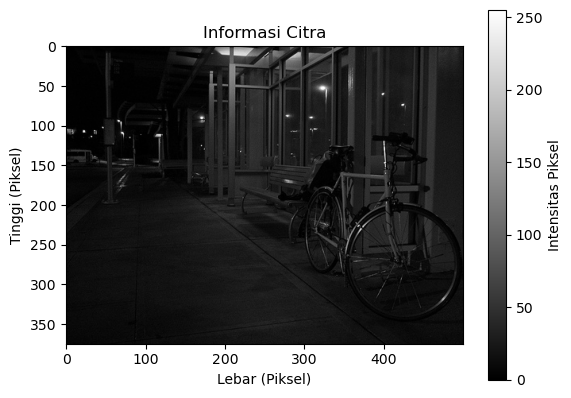

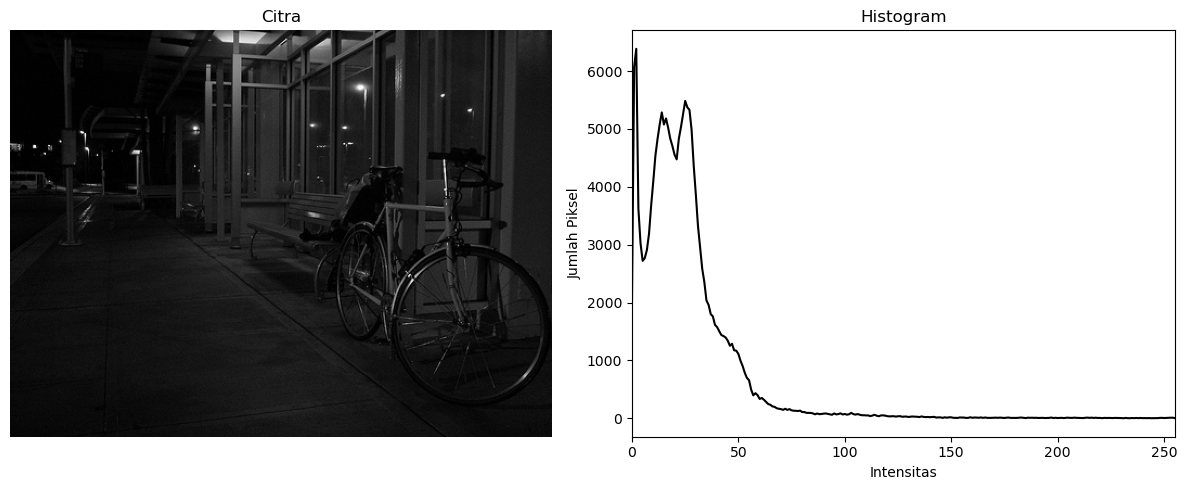

In [78]:
# aplikasi pada citra
image_path = './dataset/dark.png'
np_img = load_image(image_path)
vis_img_info(np_img)
vis_img_with_histogram(np_img)


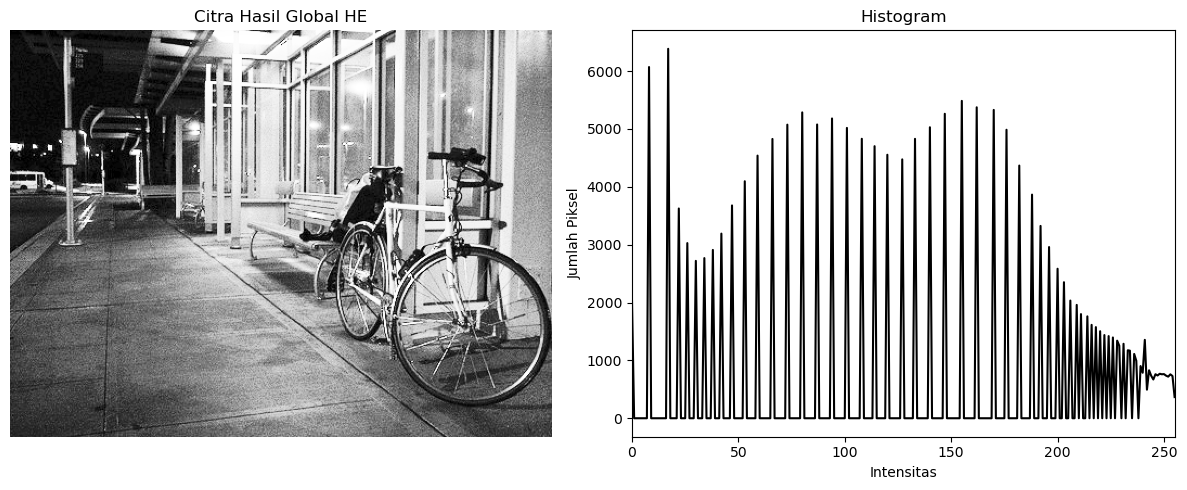

In [80]:
global_he_img = global_he(np_img)
vis_img_with_histogram(global_he_img, title="Citra Hasil Global HE")

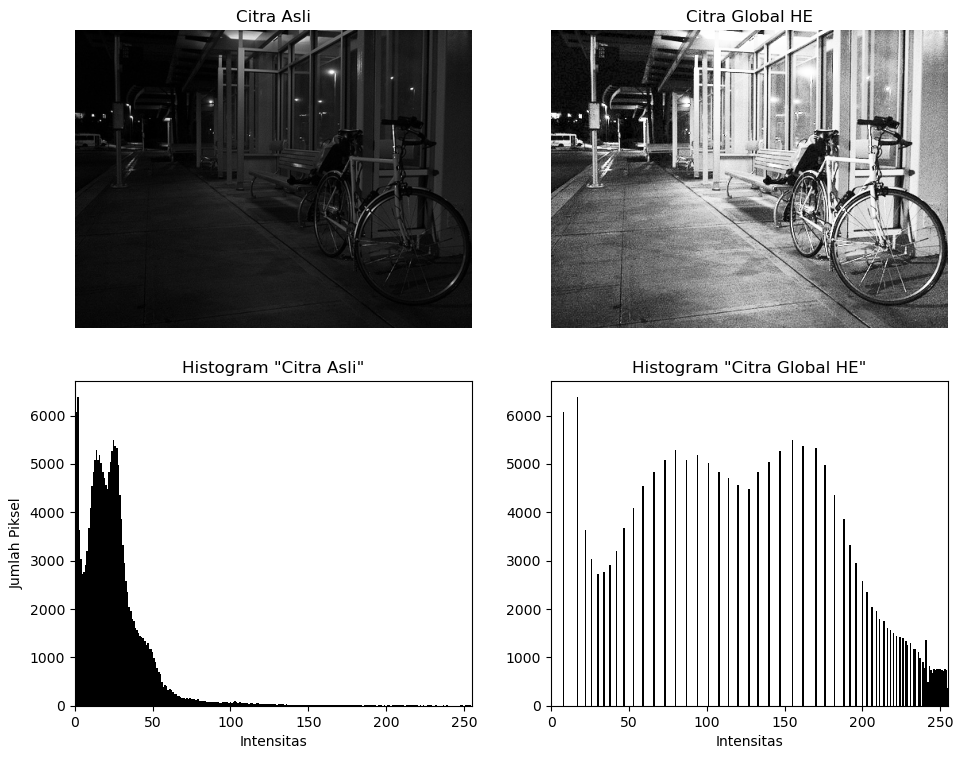

In [81]:
# komparasi
dict_results = {
    "Citra Asli": np_img,
    "Citra Global HE": global_he_img,
}

vis_images_comparisons_with_histograms(dict_results)
